In [8]:
from scipy.sparse import identity, dok_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import factorized
from scipy.linalg import solve
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
from matplotlib.cbook import flatten


# Solutions

In [9]:
def A_matrix(h, Ni, Ni2, a_p, a_s, a_w, a_e, a_n):
    
    A_0  = a_p * np.eye(Ni2, k=0)
    A_R1 = a_e * np.eye(Ni2, k=1)
    A_RN = a_n * np.eye(Ni2, k=Ni)
    A_L1 = a_w * np.eye(Ni2, k=-1)
    A_LN = a_s * np.eye(Ni2, k=-Ni)
    
    A = A_0 + A_R1 + A_RN + A_L1 + A_LN
        
    #Handle interior stack-edges
    for i in range(1, Ni):
        edge = i*Ni
        A[edge-1, edge] = 0
        A[edge, edge-1] = 0
    
    return A

In [10]:
def jacobian(N, l, h, U, A):
    
    u_inv = [(l*2)/(u**3) for u in U]
    C = np.zeros((Ni2,Ni2))

    #Fill the diagonal with u_inv
    for m in range(Ni2):
        C[m][m] = u_inv[m]

    return A + C 

In [11]:
def G(U, l, A):
    
    u_inv2 = [l/u**2 for u in U]
    
    #Set boundary conditions 
    b = np.zeros(Ni2)

    b[0:Ni] += 1/h**2                # y=0
    b[Ni2-Ni:Ni2] += 1/h**2          # y=1
    b[0:Ni2:Ni] += 1/h**2            # x=0
    b[Ni-1:Ni2:Ni] += 1/h**2         # x=1
    
    #Calculate G
    G = A@U + b - u_inv2
    
    return G

In [12]:
def newton(U , A, l, h, epsilon, max_iter):
    
    error = 1000
    n = 0 
    
    while (error > epsilon) and (n < max_iter) :
        #Make G
        Gn = G(U, l, A)
        #Make the Jacobian
        Jn = jacobian(N, l, h, U, A)
        #Make the previous U
        uprev = U
        #Update U with the Newton method
        U = uprev - np.linalg.inv(Jn)@Gn
        #Calculate the error with the largest difference
        error = max(np.abs(uprev-U))
        #Count numer of iterations
        n += 1
        
    if n == max_iter:
        print('Exceeded maximum iterations. No solution found.')
    else:
        print('Estimated U with', n, 'steps.')
    
    #Make the U vector into a matrix
    U = np.reshape(U, (Ni, Ni))
    
    #Add the boundary values
    Us = np.pad(U,((1,1), (1,1)))
    Us[0,:] = 1
    Us[N,:] = 1
    Us[:,0] = 1
    Us[:,N] = 1
   

    return Us
     

In [13]:
N = 40
l = 1.5

# Step size
h = 1/N 

# Make grid
x = np.linspace(0, 1, N+1)
y = np.linspace(0, 1, N+1) 
X,Y = np.meshgrid(x,y)

# Inner points
xi = x[1:-1]       
yi = y[1:-1] 
Xi, Yi = np.meshgrid(xi, yi)   
Ni = N-1       # Number of inner points in each direction
Ni2 = Ni**2    # Number of inner points in total
    
# Creates the A matrix
a_p = -4/h**2
a_e = 1/h**2
A = A_matrix(h, Ni, Ni2, a_p, a_e, a_e, a_e, a_e)

# Creates initial guess
U_0 = [1] * Ni2
U_0 = np.array(U_0)

# Solve wtih the newton method 
U = newton(U_0, A, l, h, 0.000000001, max_iter = 1000)

Estimated U with 4 steps.


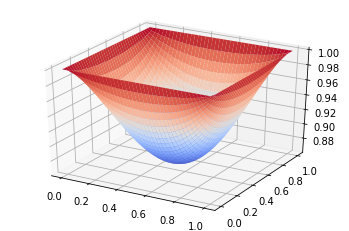

In [14]:
#Plot the figure 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,U, cmap = cm.coolwarm)
plt.savefig('sample.pdf')